PRT 565 Assignment2
Name:Bornali Rahman
ID:s372226

Data Analysis for estimation of obesity level
The purpose of this analysis is to develop a ML based model on the dataset of obesity , to estimate the obesity levels. This data set is based on eating habits and physical condition in individuals from Colombia, Peru and Mexico.

#Environment Setup and Data Load
Before starting the analysis the enciroment should set up properly by importing the necessary library.

In [2]:
from datetime import datetime
import warnings; warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [3]:
raw_path ="C:/Users/Asus/OneDrive/Documents/GitHub/ML_Assignment_2_Obesity-data/ObesityDataSet_raw_and_data_sinthetic.csv"
clean_path = "obesity_cleaned.csv"
SAVE_PNG   = False 

#Data load 
#Dataset Analysis
#Data Pre-processing

In [4]:
df = pd.read_csv(raw_path)

print("Null Data:\n", df.isnull().sum())
print("Data Shape:\n", df.shape)
print("Data Top 10 Rows: \n", df.head(10))


Null Data:
 Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
Data Shape:
 (2111, 17)
Data Top 10 Rows: 
    Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  

In [5]:
print("Data Type:\n", df.dtypes)
print("Data duplicate:\n", df.duplicated().sum())


Data Type:
 Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object
Data duplicate:
 24


Variable Name
Demographic	Variables
1.Gender
2.Age


Independent variables
Height
Weight
family_history_with_overweight:Has a family member suffered or suffers from overweight?
FAVC :Do you eat high caloric food frequently?
FCVC:Do you usually eat vegetables in your meals?
NCP:How many main meals do you have daily?
CAEC : Do you eat any food between meals?	
SMOKE :Do you smoke?
CH20 :How much water do you drink daily?
SCC :Do you monitor the calories you eat daily?
FAF:How often do you have physical activity?
TUE :How much time do you use technological devices (cellphone, videogames, TV)?		
CALC:How often do you drink alcohol?	
MTRANS :Which transportation do you usually use?

Target Variables
NObeyesdad : Obesity level


Data Preparation

In [ ]:
Data Standardization

In [6]:
# Standardize column names and fix CH20 -> CH2O if present
df.columns = [c.strip() for c in df.columns]
if "CH20" in df.columns and "CH2O" not in df.columns:
    df = df.rename(columns={"CH20": "CH2O"})

In [ ]:
Feature encoding

In [8]:
# ---------- SCHEMA (from your table) ----------
categorical_cols = [
    "Gender","family_history_with_overweight","FAVC","CAEC","SMOKE",
    "SCC","CALC","MTRANS","NObeyesdad"   # target
]
# These are often listed as Integer in some tables but can have decimals in files.
# We'll try integer, fall back to float automatically.
integer_cols    = ["FCVC","TUE"]
continuous_cols = ["Age","Height","Weight","NCP","CH2O","FAF"]  # BMI added below

In [9]:
# Safe numeric conversion: keeps float if decimals exist
def safe_to_int_or_float(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors="coerce")
    s_nz  = s_num.dropna()
    # If all non-missing are whole numbers, keep integer; else float
    if len(s_nz) and np.all(np.isclose(s_nz, np.round(s_nz))):
        return s_num.round().astype("Int64")
    return s_num  # leave as float

# Apply dtype intentions
for c in integer_cols:
    if c in df.columns:
        df[c] = safe_to_int_or_float(df[c])

for c in continuous_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

for c in categorical_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

In [10]:
# Simple cleaning: drop exact duplicates 
dfc = df.drop_duplicates()

print("Data Shape Before:\n", df.shape)
print("Data Shape After:\n", dfc.shape)

Data Shape Before:
 (2111, 17)
Data Shape After:
 (2087, 17)


Feature Engineering

In [11]:
# Add BMI if possible
if {"Height","Weight"}.issubset(dfc.columns) and "BMI" not in dfc.columns:
    dfc["BMI"] = pd.to_numeric(dfc["Weight"], errors="coerce") / (pd.to_numeric(dfc["Height"], errors="coerce")**2)

In [12]:
# Impute only for EDA views (median for numeric, mode for categorical)
num_cols = dfc.select_dtypes(include=["number","Int64"]).columns.tolist()
cat_cols = dfc.select_dtypes(include=["category","object"]).columns.tolist()
for c in num_cols:
    if dfc[c].isna().any():
        dfc[c] = dfc[c].fillna(dfc[c].median())
for c in cat_cols:
    if dfc[c].isna().any():
        dfc[c] = dfc[c].fillna(dfc[c].mode().iloc[0])

# Save cleaned copy for modeling later
dfc.to_csv(clean_path, index=False)
print("\nSaved cleaned CSV ->", clean_path)


Saved cleaned CSV -> obesity_cleaned.csv


Exploratory Data Analysis (EDA)

In [13]:
# ---------- Basic stats ----------
print("\nNumeric summary:")
display(dfc[num_cols].describe().T)

print("\nTop counts for categorical variables:")
for c in cat_cols:
    vc = dfc[c].value_counts(dropna=False)
    display(pd.DataFrame({"count": vc, "percent": (vc/len(dfc)*100).round(2)}).head(20))


Numeric summary:


,count,mean,std,min,25%,50%,75%,max
Age,2087.0,24.353090,6.368801,14.000000,19.915937,22.847618,26.000000,61.000000
Height,2087.0,1.702674,0.093186,1.450000,1.630178,1.701584,1.769491,1.980000
Weight,2087.0,86.858730,26.190847,39.000000,66.000000,83.101100,108.015907,173.000000
FCVC,2087.0,2.421466,0.534737,1.000000,2.000000,2.396265,3.000000,3.000000
NCP,2087.0,2.701179,0.764614,1.000000,2.697467,3.000000,3.000000,4.000000
CH2O,2087.0,2.004749,0.608284,1.000000,1.590922,2.000000,2.466193,3.000000
FAF,2087.0,1.012812,0.853475,0.000000,0.124505,1.000000,1.678102,3.000000
TUE,2087.0,0.663035,0.608153,0.000000,0.000000,0.630866,1.000000,2.000000
BMI,2087.0,29.765758,8.024934,12.998685,24.368897,28.896224,36.095538,50.811753



Top counts for categorical variables:


,count,percent
Gender,,
Male,1052,50.41
Female,1035,49.59


,count,percent
family_history_with_overweight,,
yes,1722,82.51
no,365,17.49


,count,percent
FAVC,,
yes,1844,88.36
no,243,11.64


,count,percent
CAEC,,
Sometimes,1761,84.38
Frequently,236,11.31
Always,53,2.54
no,37,1.77


,count,percent
SMOKE,,
no,2043,97.89
yes,44,2.11


,count,percent
SCC,,
no,1991,95.4
yes,96,4.6


,count,percent
CALC,,
Sometimes,1380,66.12
no,636,30.47
Frequently,70,3.35
Always,1,0.05


,count,percent
MTRANS,,
Public_Transportation,1558,74.65
Automobile,456,21.85
Walking,55,2.64
Motorbike,11,0.53
Bike,7,0.34


,count,percent
NObeyesdad,,
Obesity_Type_I,351,16.82
Obesity_Type_III,324,15.52
Obesity_Type_II,297,14.23
Overweight_Level_II,290,13.90
Normal_Weight,282,13.51
Overweight_Level_I,276,13.22
Insufficient_Weight,267,12.79


#Univariate Data Analysis

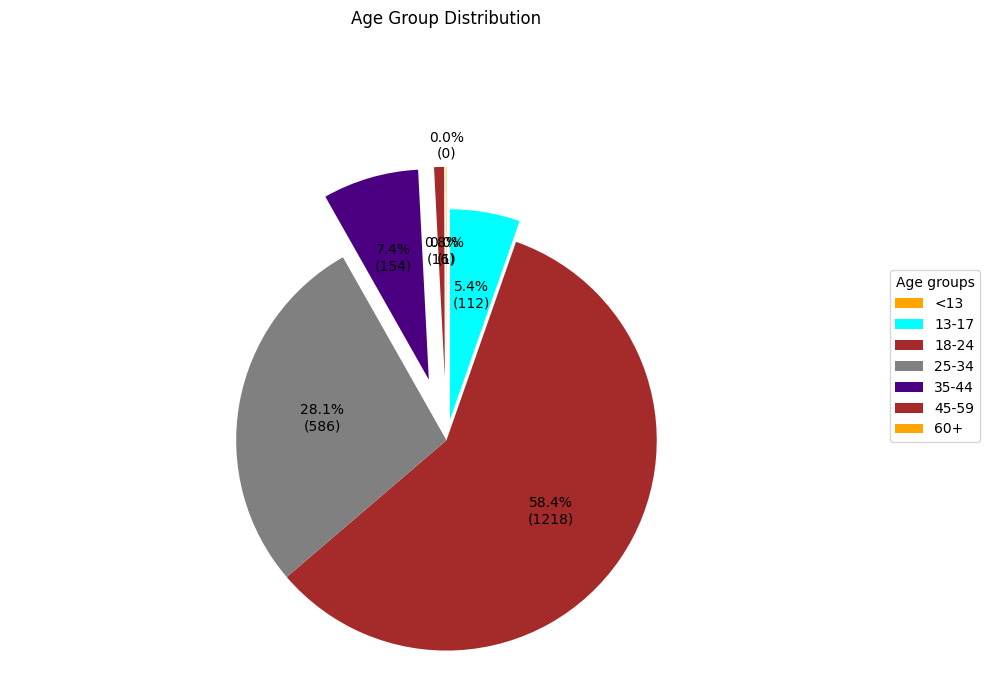

In [42]:
#Demographic Variables 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use your cleaned frame if available; else fall back to df
if "dfc" in globals():
    data = dfc.copy()
else:
    data = df.copy()  # assumes df already loaded

# --- Age groups (bins + labels) ---
age = pd.to_numeric(data["Age"], errors="coerce")
bins   = [0, 13, 18, 25, 35, 45, 60,100]
labels = ["<13", "13-17", "18-24", "25-34", "35-44", "45-59", "60+"]

data["AgeGroup"] = pd.cut(age, bins=bins, labels=labels, right=False)

# Counts in the desired label order (even if some bins are empty)
counts = data["AgeGroup"].value_counts().reindex(labels, fill_value=0)

# --- Explode, colors, wedge style ---
# manual explode (same length as labels)
explode = (0.80, 0.10, 0.00, 0.00, 0.30, 0.30, 0.30)

colors  = ("orange", "cyan", "brown", "grey", "indigo", "brown", "orange")
wp      = {"linewidth": 1}

# % + count on the slices
def autopct_pct_count(pct):
    n = int(round(pct/100.0 * counts.sum()))
    return f"{pct:.1f}%\n({n})"

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    counts.values,
    explode=explode,
    colors=colors,
    startangle=90,
    counterclock=False,
    autopct=autopct_pct_count,
    wedgeprops=wp,
    textprops=dict(color="black")
)

ax.axis("equal")  # perfect circle
ax.set_title("Age Group Distribution")
ax.legend(wedges, counts.index, title="Age groups",
          loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


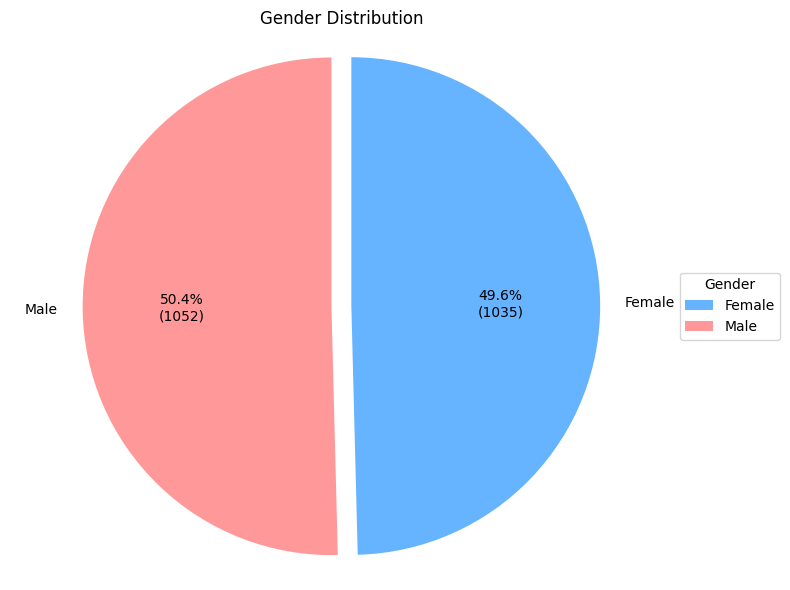

In [45]:
#Gender
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# use dfc if you created it; otherwise fall back to df
data = dfc.copy() if "dfc" in globals() else df.copy()

# Clean/standardise Gender values
s = data["Gender"].astype(str).str.strip().str.title()   # e.g., 'Male', 'Female'

# Desired order for legend/labels (falls back to observed order if different)
gender_order = ["Female", "Male"] if {"Female","Male"}.issubset(set(s.unique())) \
               else list(s.value_counts().index)

# Counts in that order
counts = s.value_counts().reindex(gender_order, fill_value=0)

# Style: explode the biggest slice a bit
explode = [0.08 if i == np.argmax(counts.values) else 0.0 for i in range(len(counts))]
colors  = ["#66b3ff", "#ff9999"][:len(counts)]          # 2 colors
wp      = {"linewidth": 1}

def autopct_pct_count(pct):
    n = int(round(pct/100.0 * counts.sum()))
    return f"{pct:.1f}%\n({n})"

fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    counts.values,
    labels=counts.index,
    explode=explode,
    colors=colors,
    startangle=90,
    counterclock=False,
    autopct=autopct_pct_count,
    wedgeprops=wp,
    textprops={"color": "black"}
)

ax.axis("equal")
ax.set_title("Gender Distribution")
ax.legend(wedges, counts.index, title="Gender", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


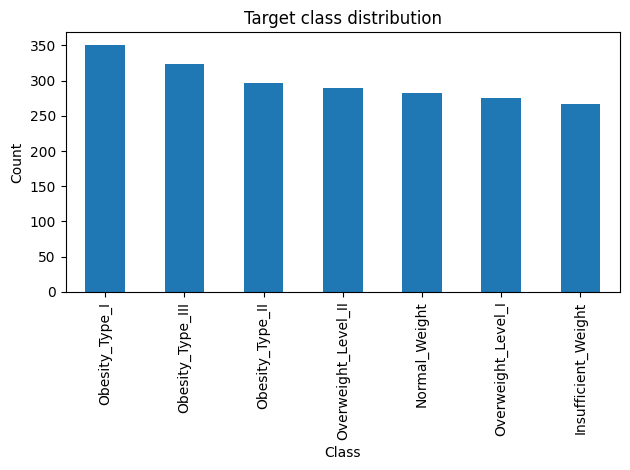


Target distribution (%):


,percent
NObeyesdad,
Obesity_Type_I,16.82
Obesity_Type_III,15.52
Obesity_Type_II,14.23
Overweight_Level_II,13.90
Normal_Weight,13.51
Overweight_Level_I,13.22
Insufficient_Weight,12.79


In [ ]:
# ---------- Target distribution ----------
target = "NObeyesdad" if "NObeyesdad" in dfc.columns else None
if target:
    vc = dfc[target].value_counts()
    ax = vc.plot(kind="bar", title="Target class distribution")
    ax.set_xlabel("Class"); ax.set_ylabel("Count"); plt.tight_layout(); 
    if SAVE_PNG: plt.savefig("plot_target_distribution.png", dpi=150)
    plt.show()
    print("\nTarget distribution (%):")
    display((vc/len(dfc)*100).round(2).to_frame("percent"))


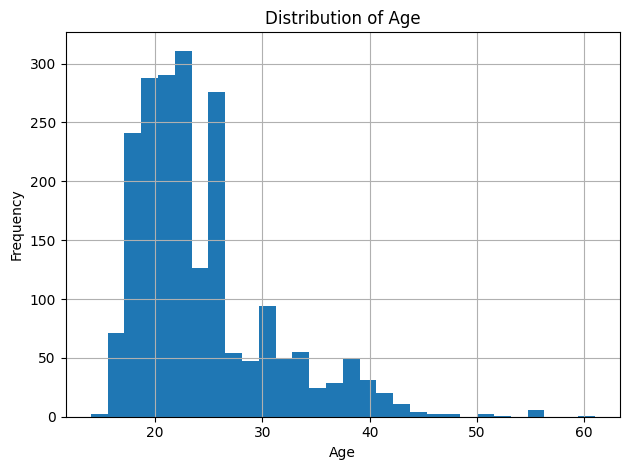

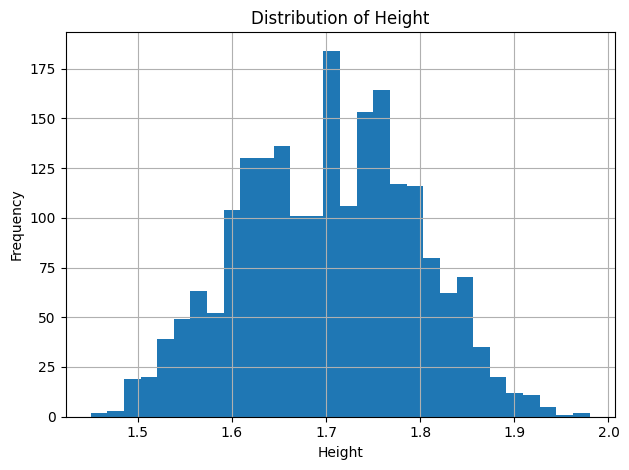

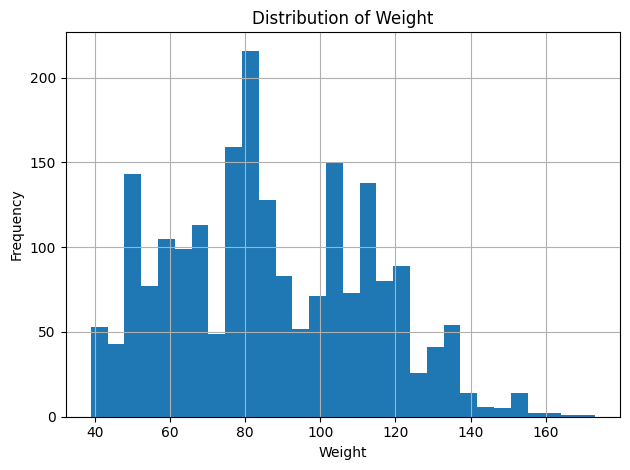

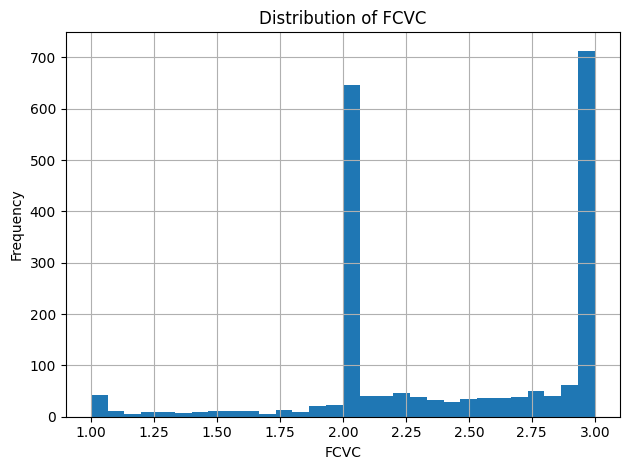

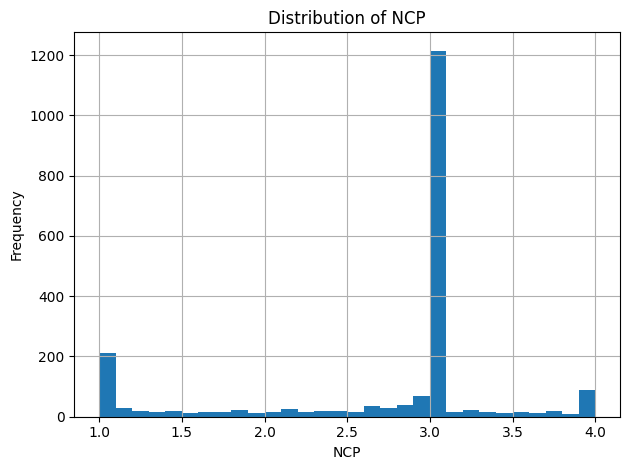

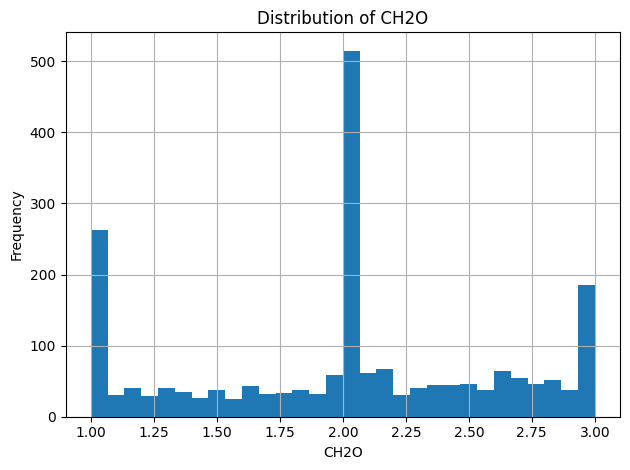

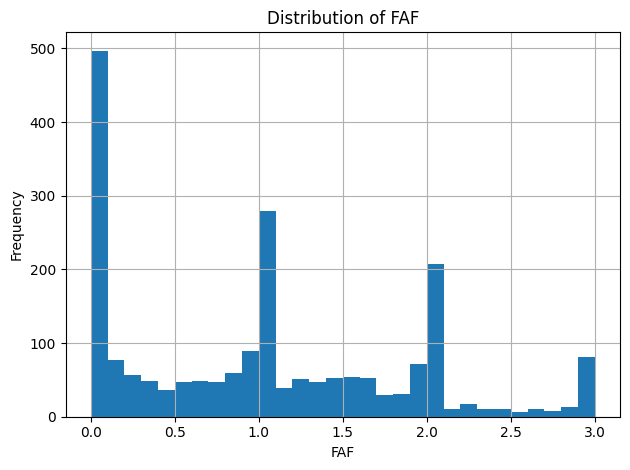

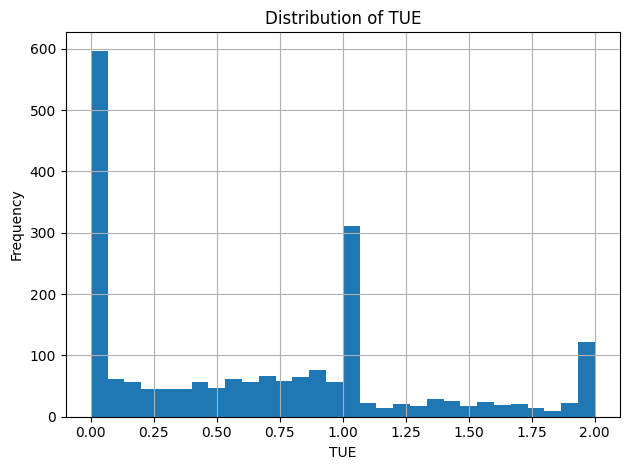

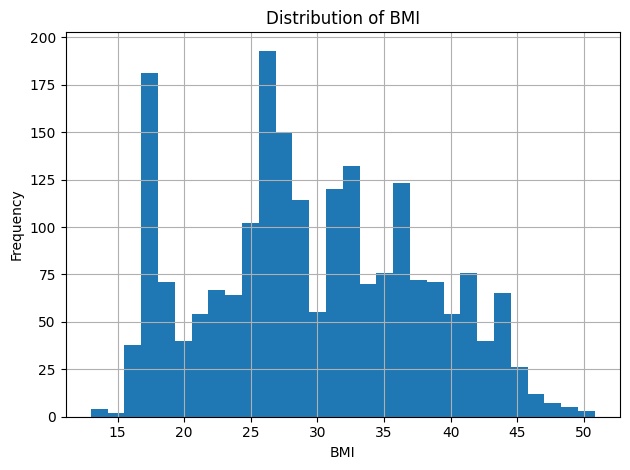

In [ ]:
 num_cols = dfc.select_dtypes(include=["number", "Int64"]).columns.tolist()

for col in num_cols:
    dfc[col].dropna().hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

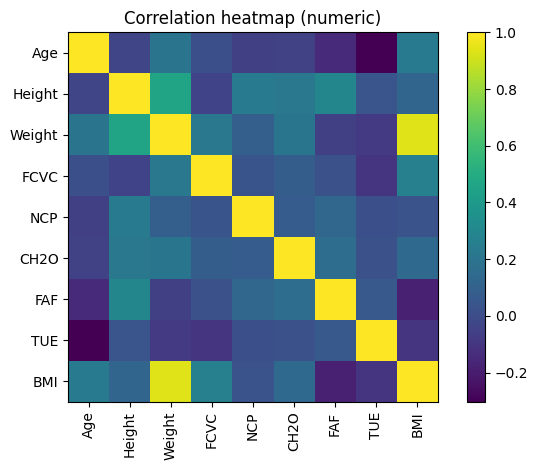

In [ ]:
# ---------- Correlation heatmap ----------
if len(num_cols) >= 2:
    corr = dfc[num_cols].corr()
    plt.imshow(corr, interpolation="nearest")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation heatmap (numeric)")
    plt.colorbar(); plt.tight_layout()
    if SAVE_PNG: plt.savefig("corr_heatmap.png", dpi=150)
    plt.show()


Age by NObeyesdad:


,count,mean,std,median,min,max
NObeyesdad,,,,,,
Insufficient_Weight,267,19.771687,2.688101,19.211640,16.0,39.0
Normal_Weight,282,21.758865,5.121861,21.000000,14.0,61.0
Obesity_Type_I,351,25.884941,7.755700,22.975526,15.0,52.0
Obesity_Type_II,297,28.233785,4.868199,27.186873,20.0,41.0
Obesity_Type_III,324,23.495554,2.764324,25.369387,18.0,26.0
Overweight_Level_I,276,23.540309,6.254105,21.305929,16.0,55.0
Overweight_Level_II,290,26.996981,8.061061,24.000000,17.0,56.0


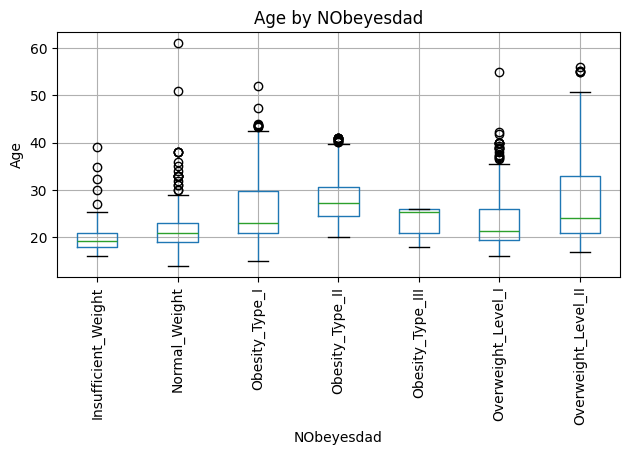


Height by NObeyesdad:


,count,mean,std,median,min,max
NObeyesdad,,,,,,
Insufficient_Weight,267,1.693572,0.098360,1.704223,1.52,1.90
Normal_Weight,282,1.676950,0.095007,1.660000,1.50,1.93
Obesity_Type_I,351,1.693804,0.098414,1.681855,1.50,1.98
Obesity_Type_II,297,1.771795,0.072723,1.767140,1.60,1.92
Obesity_Type_III,324,1.687559,0.065263,1.668995,1.56,1.87
Overweight_Level_I,276,1.691277,0.097154,1.698198,1.45,1.90
Overweight_Level_II,290,1.703748,0.089441,1.703914,1.48,1.93


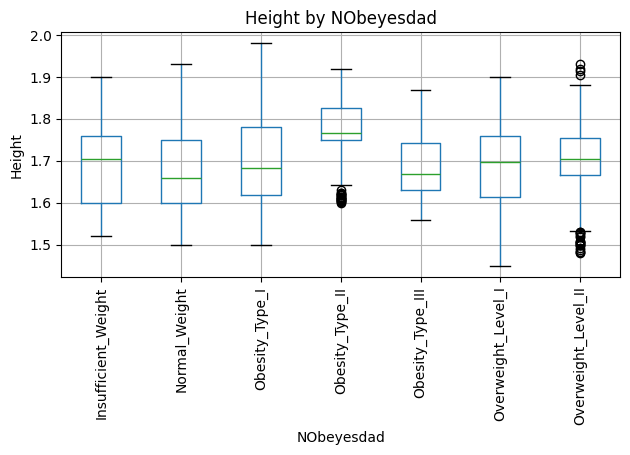


Weight by NObeyesdad:


,count,mean,std,median,min,max
NObeyesdad,,,,,,
Insufficient_Weight,267,50.013190,5.985004,50.000000,39.0,65.0
Normal_Weight,282,62.164894,9.322659,61.000000,42.3,87.0
Obesity_Type_I,351,92.870198,11.485987,90.744965,75.0,125.0
Obesity_Type_II,297,115.305311,8.024320,117.792268,93.0,130.0
Obesity_Type_III,324,120.941114,15.532225,112.049308,102.0,173.0
Overweight_Level_I,276,74.483261,8.627636,75.000000,53.0,91.0
Overweight_Level_II,290,82.085271,8.450932,82.000000,60.0,102.0


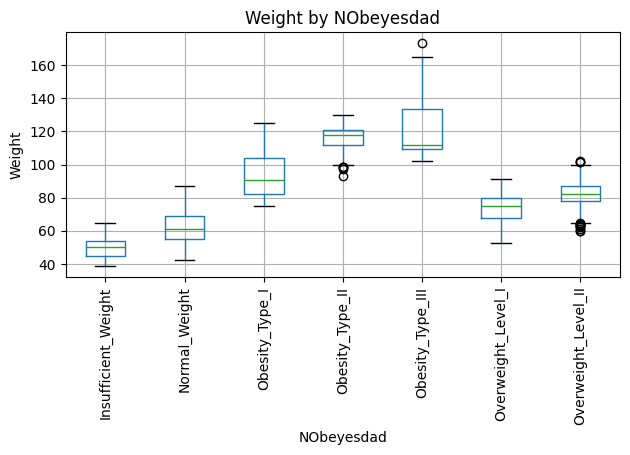


FCVC by NObeyesdad:


,count,mean,std,median,min,max
NObeyesdad,,,,,,
Insufficient_Weight,267,2.474811,0.586052,2.703436,1.0,3.0
Normal_Weight,282,2.336879,0.593549,2.000000,1.0,3.0
Obesity_Type_I,351,2.186050,0.431998,2.000000,1.0,3.0
Obesity_Type_II,297,2.391284,0.489808,2.432355,1.0,3.0
Obesity_Type_III,324,3.000000,0.000000,3.000000,3.0,3.0
Overweight_Level_I,276,2.278055,0.490959,2.038352,1.0,3.0
Overweight_Level_II,290,2.260578,0.453272,2.000000,1.0,3.0


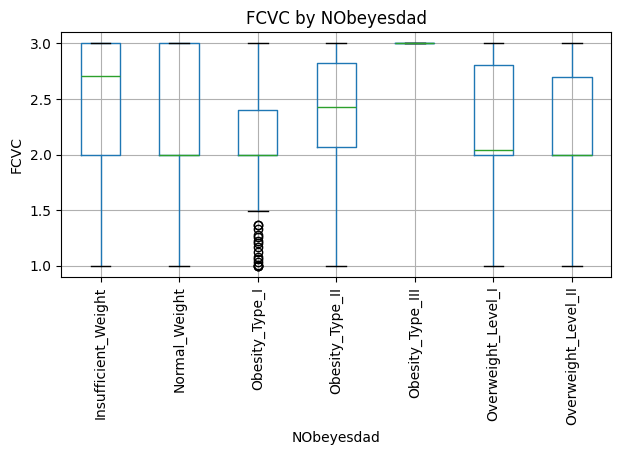


NCP by NObeyesdad:


,count,mean,std,median,min,max
NObeyesdad,,,,,,
Insufficient_Weight,267,2.942763,0.878411,3.0000,1.0,4.0
Normal_Weight,282,2.748227,0.866794,3.0000,1.0,4.0
Obesity_Type_I,351,2.431862,0.789471,3.0000,1.0,3.0
Obesity_Type_II,297,2.744555,0.578765,3.0000,1.0,4.0
Obesity_Type_III,324,3.000000,0.000000,3.0000,3.0,3.0
Overweight_Level_I,276,2.580519,0.923669,3.0000,1.0,4.0
Overweight_Level_II,290,2.495529,0.752908,2.9785,1.0,4.0


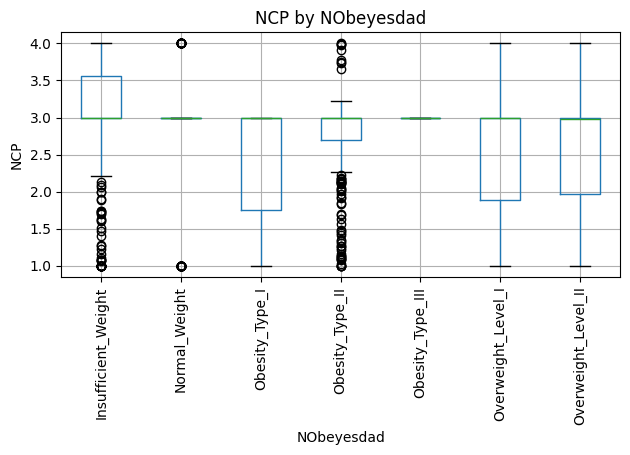


CH2O by NObeyesdad:


,count,mean,std,median,min,max
NObeyesdad,,,,,,
Insufficient_Weight,267,1.883852,0.598282,2.000000,1.0,3.0
Normal_Weight,282,1.858156,0.637852,2.000000,1.0,3.0
Obesity_Type_I,351,2.112218,0.624644,2.014990,1.0,3.0
Obesity_Type_II,297,1.877658,0.553123,2.001208,1.0,3.0
Obesity_Type_III,324,2.208493,0.603782,2.431036,1.0,3.0
Overweight_Level_I,276,2.010979,0.591910,2.000000,1.0,3.0
Overweight_Level_II,290,2.025133,0.553960,2.000000,1.0,3.0


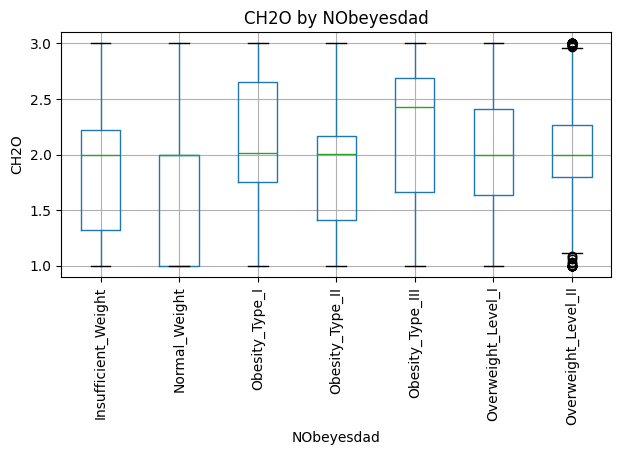


FAF by NObeyesdad:


,count,mean,std,median,min,max
NObeyesdad,,,,,,
Insufficient_Weight,267,1.273542,0.847156,1.374670,0.0,3.0
Normal_Weight,282,1.251773,1.021345,1.000000,0.0,3.0
Obesity_Type_I,351,0.986748,0.894675,0.990642,0.0,3.0
Obesity_Type_II,297,0.971857,0.581238,0.994422,0.0,2.0
Obesity_Type_III,324,0.664817,0.732864,0.222654,0.0,2.0
Overweight_Level_I,276,1.059677,0.872909,0.995897,0.0,3.0
Overweight_Level_II,290,0.958072,0.824744,0.960716,0.0,3.0


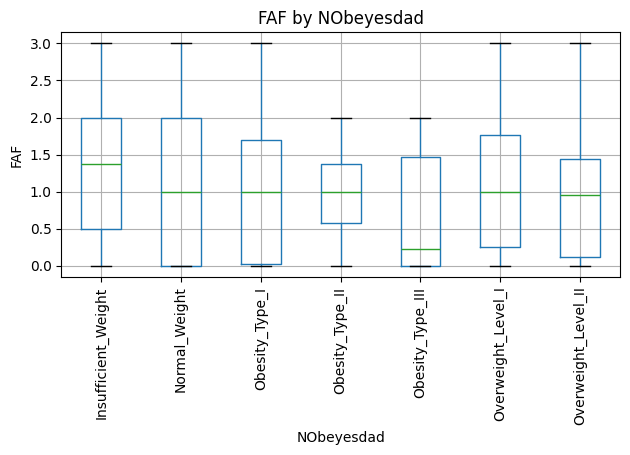


TUE by NObeyesdad:


,count,mean,std,median,min,max
NObeyesdad,,,,,,
Insufficient_Weight,267,0.847689,0.637021,1.000000,0.0,2.0
Normal_Weight,282,0.677305,0.689615,1.000000,0.0,2.0
Obesity_Type_I,351,0.676743,0.687897,0.537659,0.0,2.0
Obesity_Type_II,297,0.515186,0.563862,0.343635,0.0,2.0
Obesity_Type_III,324,0.604623,0.281852,0.656856,0.0,1.0
Overweight_Level_I,276,0.644086,0.680131,0.410967,0.0,2.0
Overweight_Level_II,290,0.697275,0.588436,0.754274,0.0,2.0


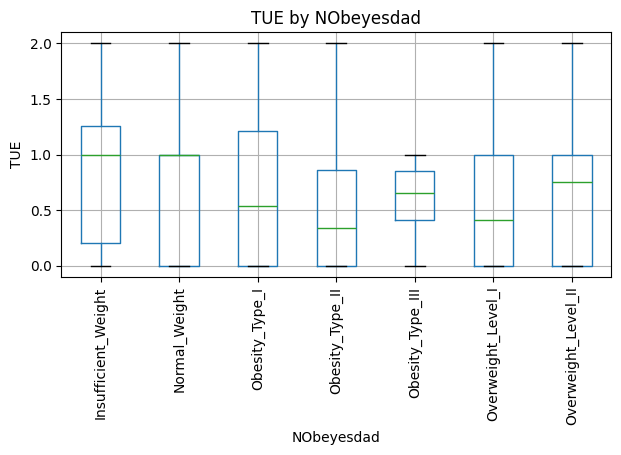


BMI by NObeyesdad:


,count,mean,std,median,min,max
NObeyesdad,,,,,,
Insufficient_Weight,267,17.390730,0.787144,17.532455,12.998685,19.082206
Normal_Weight,282,22.007841,1.848433,22.122809,18.491124,24.913495
Obesity_Type_I,351,32.255636,1.130957,32.200035,29.911958,35.171095
Obesity_Type_II,297,36.723424,1.290127,36.417803,34.048509,39.786652
Obesity_Type_III,324,42.273746,2.578689,41.942617,36.774400,50.811753
Overweight_Level_I,276,25.956179,0.658815,25.951557,22.826739,28.769607
Overweight_Level_II,290,28.215232,0.827862,28.152417,25.713513,30.362877


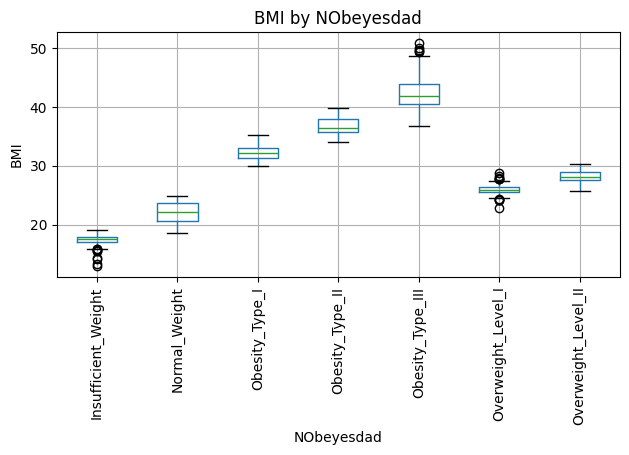

In [ ]:
# ---------- Numeric vs Target (grouped stats + boxplots) ----------
if target:
    for col in num_cols:
        tbl = dfc.groupby(target)[col].agg(["count","mean","std","median","min","max"])
        print(f"\n{col} by {target}:")
        display(tbl)
        try:
            dfc.boxplot(column=col, by=target, rot=90)
            plt.title(f"{col} by {target}"); plt.suptitle("")
            plt.xlabel(target); plt.ylabel(col); plt.tight_layout()
            if SAVE_PNG: plt.savefig(f"box_{col}_by_target.png", dpi=150)
            plt.show()
        except Exception as e:
            print(f"(Could not boxplot {col}: {e})")

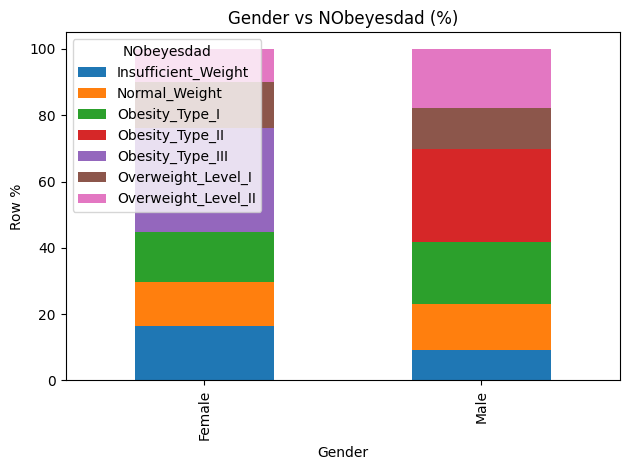

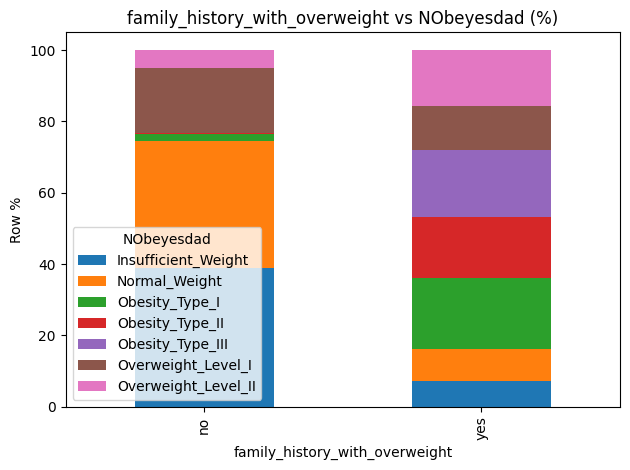

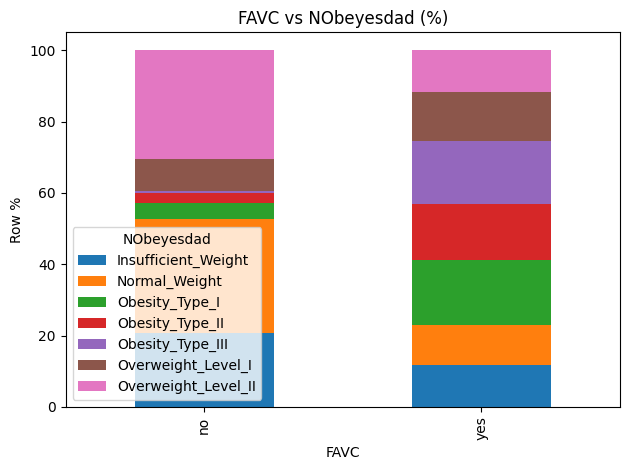

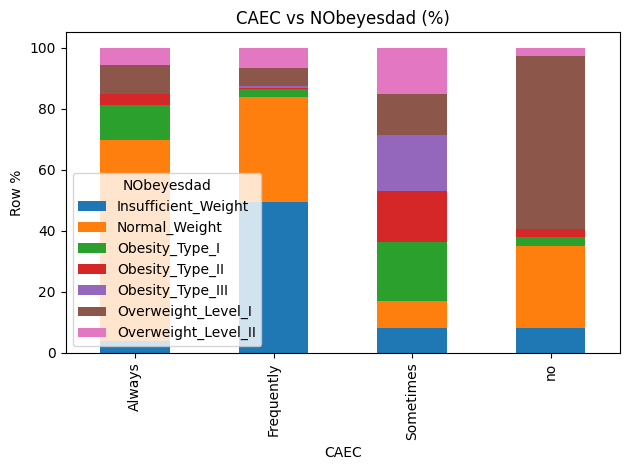

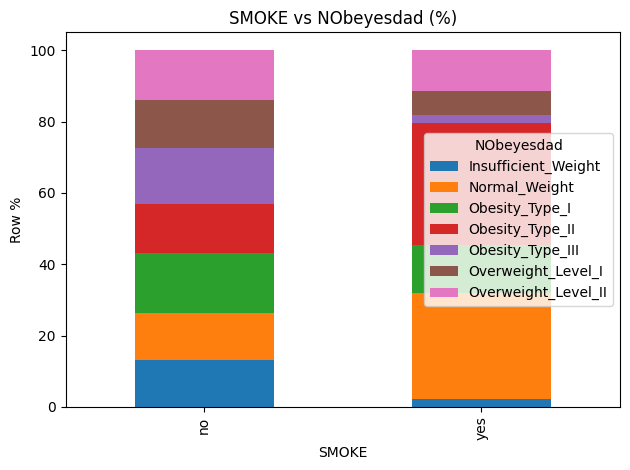

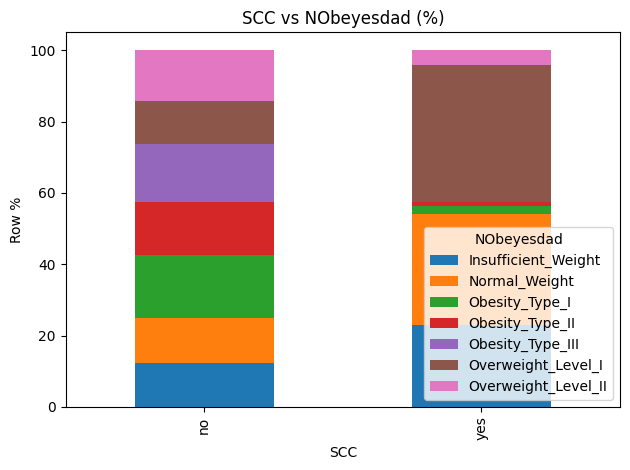

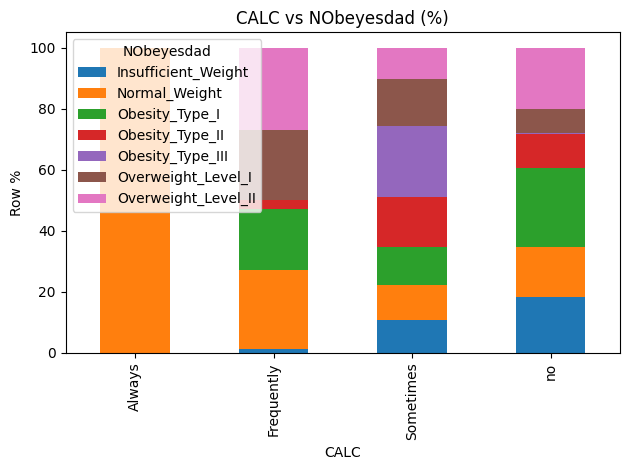

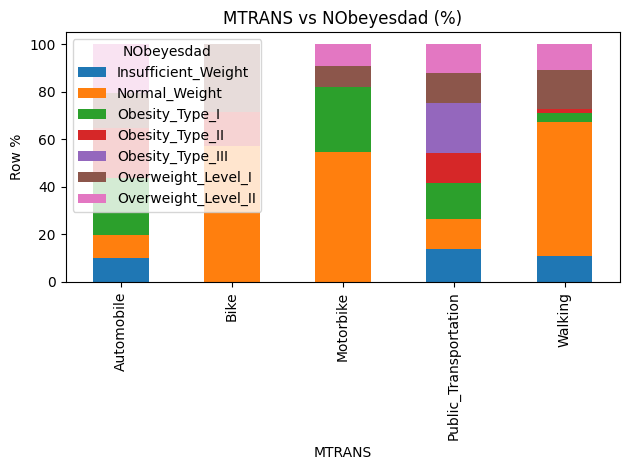

In [ ]:
# ---------- Categorical vs Target (stacked %) ----------
if target:
    for c in [x for x in cat_cols if x != target]:
        ct = pd.crosstab(dfc[c], dfc[target], normalize="index")*100
        ct.plot(kind="bar", stacked=True, title=f"{c} vs {target} (%)")
        plt.ylabel("Row %"); plt.tight_layout()
        if SAVE_PNG: plt.savefig(f"stacked_{c}_vs_target.png", dpi=150)
        plt.show()

Annomalies Treatment

In [46]:
# ===== Treat anomalies: rule-based caps + IQR winsorization =====
import numpy as np, pandas as pd

# Use your cleaned dfc if available, else df
X = dfc.copy() if "dfc" in globals() else df.copy()


# Ensure numeric for likely continuous fields; create BMI if missing
for c in ["Age","Height","Weight","NCP","CH2O","FAF","FCVC","TUE"]:
    if c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
if {"Height","Weight"}.issubset(X.columns) and "BMI" not in X.columns:
    X["BMI"] = X["Weight"] / (X["Height"]**2)

# ---------- 1) RULE-BASED BOUNDS (domain) ----------
# (Tweak bounds if your instructor provided specific scales)
bounds = {
    "Age":   (10, 90),          # yrs
    "Height":(1.2, 2.2),        # meters
    "Weight":(30, 250),         # kg
    "BMI":   (12, 60),          # kg/m^2 (practical)
    # survey scales
    "FCVC":  (1, 3),            # veggies freq
    "NCP":   (1, 4),            # main meals/day
    "CH2O":  (1, 3),            # water consumption
    "FAF":   (0, 3),            # physical activity
    "TUE":   (0, 2),            # tech use
}

rule_log = {}
for col, (lo, hi) in bounds.items():
    if col in X.columns:
        s = X[col].copy()
        before_low  = (s < lo).sum()
        before_high = (s > hi).sum()
        X[col] = s.clip(lo, hi)
        rule_log[col] = {"capped_low": int(before_low), "capped_high": int(before_high)}

print("Rule-based caps applied:")
for k,v in rule_log.items():
    print(f" - {k:>5}: low→{v['capped_low']}, high→{v['capped_high']}")

# ---------- 2) DISTRIBUTION-BASED WINSORIZATION (IQR) ----------
def winsorize_iqr(series, k=1.5):
    s = pd.to_numeric(series, errors="coerce")
    q1 = s.quantile(0.25); q3 = s.quantile(0.75)
    iqr = q3 - q1
    lo  = q1 - k*iqr
    hi  = q3 + k*iqr
    s2  = s.clip(lo, hi)
    return s2, lo, hi, int((s < lo).sum()), int((s > hi).sum())

iqr_cols = [c for c in ["Age","Height","Weight","BMI"] if c in X.columns]
iqr_log = {}
for col in iqr_cols:
    X[col], lo, hi, nlow, nhigh = winsorize_iqr(X[col], k=1.5)
    iqr_log[col] = {"iqr_low": nlow, "iqr_high": nhigh, "lo": float(lo), "hi": float(hi)}

print("\nIQR winsorization (after rule caps):")
for k,v in iqr_log.items():
    print(f" - {k:>6}: low→{v['iqr_low']}, high→{v['iqr_high']} | fences [{v['lo']:.2f}, {v['hi']:.2f}]")

# Optional: round survey scales back to neat steps
for col in ["FCVC","NCP","CH2O","FAF","TUE"]:
    if col in X.columns:
        X[col] = X[col].round(0)

# Keep a copy to continue modeling
df_anom_treated = X.copy()
print("\nAnomaly treatment complete. Use `df_anom_treated` going forward.")


Rule-based caps applied:
 -   Age: low→0, high→0
 - Height: low→0, high→0
 - Weight: low→0, high→0
 -   BMI: low→0, high→0
 -  FCVC: low→0, high→0
 -   NCP: low→0, high→0
 -  CH2O: low→0, high→0
 -   FAF: low→0, high→0
 -   TUE: low→0, high→0

IQR winsorization (after rule caps):
 -    Age: low→0, high→167 | fences [10.79, 35.13]
 - Height: low→0, high→1 | fences [1.42, 1.98]
 - Weight: low→0, high→1 | fences [2.98, 171.04]
 -    BMI: low→0, high→0 | fences [6.78, 53.69]

Anomaly treatment complete. Use `df_anom_treated` going forward.


,feature,n,outliers,pct_outliers,lower_fence,upper_fence,min,max
3,NCP,2087,577,27.65,2.243667,3.453799,1.000000,4.000000
0,Age,2087,167,8.00,10.789844,35.126094,14.000000,61.000000
1,Height,2087,1,0.05,1.421209,1.978461,1.450000,1.980000
2,Weight,2087,1,0.05,2.976140,171.039767,39.000000,173.000000
4,CH2O,2087,0,0.00,0.278015,3.779099,1.000000,3.000000
5,FAF,2087,0,0.00,-2.205890,4.008497,0.000000,3.000000
6,FCVC,2087,0,0.00,0.500000,4.500000,1.000000,3.000000
7,TUE,2087,0,0.00,-1.500000,2.500000,0.000000,2.000000
8,BMI,2087,0,0.00,6.778936,53.685498,12.998685,50.811753


,feature,class,n,outliers,pct_outliers,lower_fence,upper_fence
0,Age,Normal_Weight,282,20,7.09,13.000000,29.000000
1,Age,Overweight_Level_I,276,19,6.88,9.748562,35.750863
5,Age,Obesity_Type_II,297,12,4.04,15.382760,39.914600
3,Age,Obesity_Type_I,351,9,2.56,7.516506,43.140184
4,Age,Insufficient_Weight,267,5,1.87,13.481273,25.531212
2,Age,Overweight_Level_II,290,5,1.72,3.000801,50.999519
6,Age,Obesity_Type_III,324,0,0.00,13.552167,33.468700
57,BMI,Overweight_Level_I,276,11,3.99,24.419239,27.448191
60,BMI,Insufficient_Weight,267,9,3.37,15.832668,19.133038
62,BMI,Obesity_Type_III,324,5,1.54,35.720057,48.709731


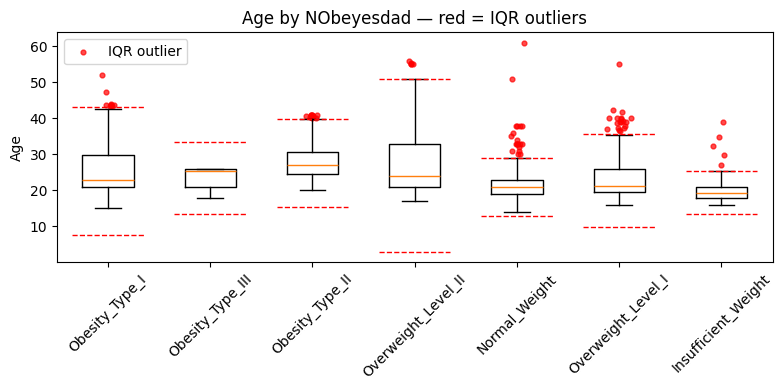

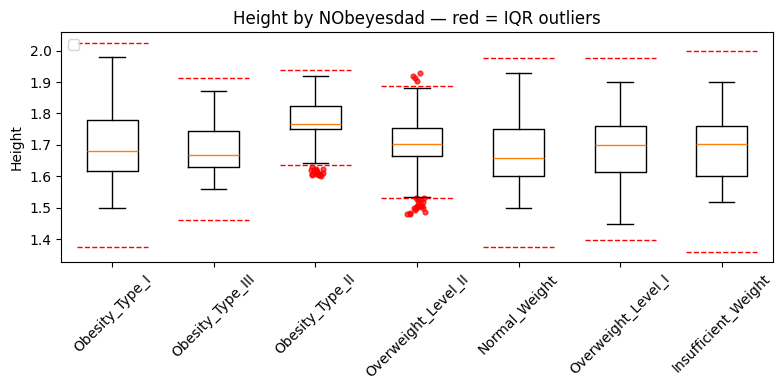

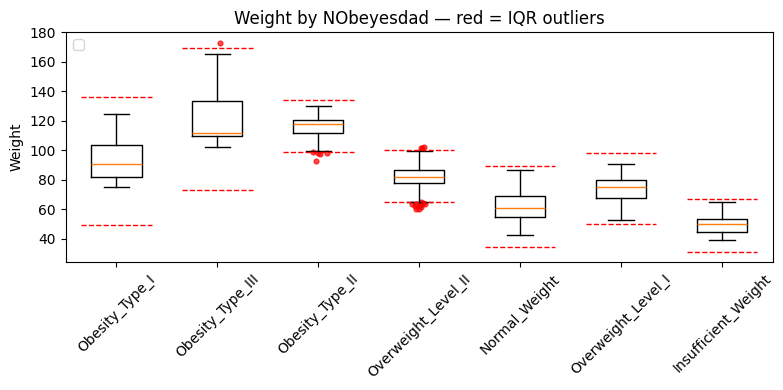

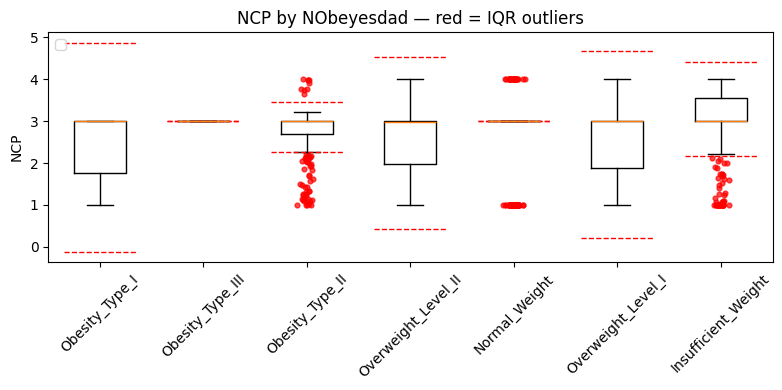

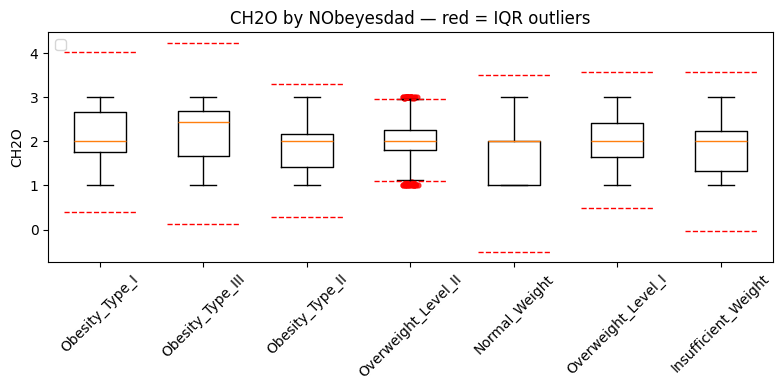

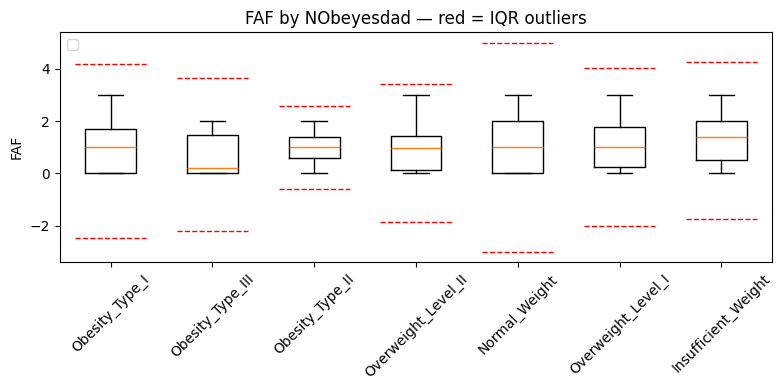

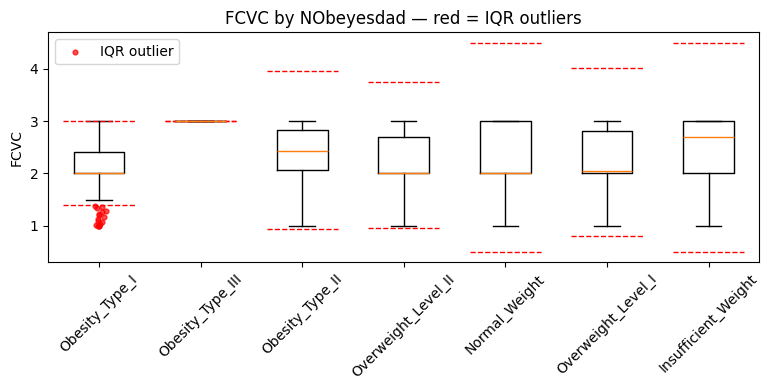

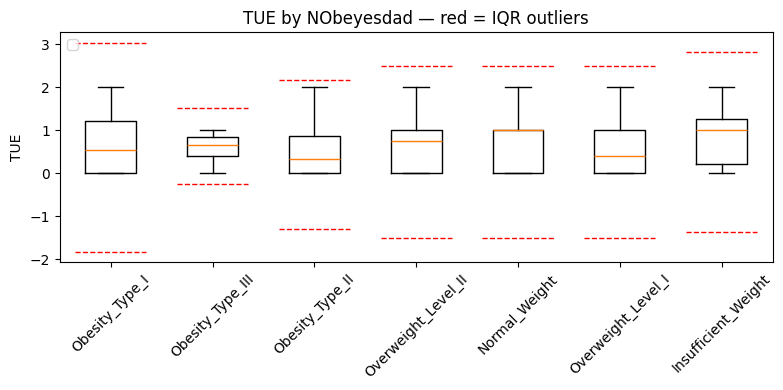

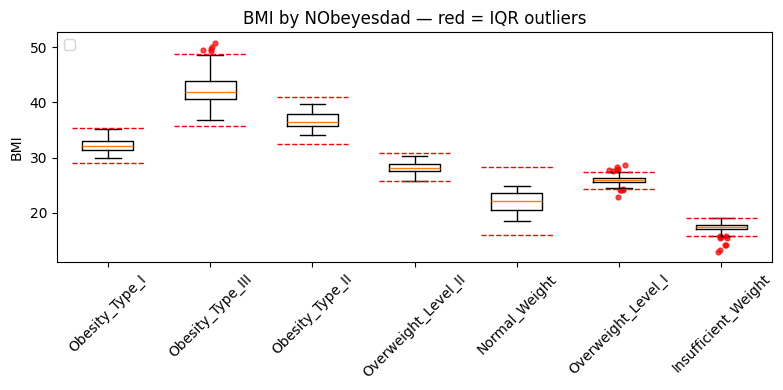

In [47]:
# =========================
# Check anomalies in boxplots (IQR rule)
# =========================
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Use cleaned frame if available; else fall back to df
X = dfc.copy() if "dfc" in globals() else df.copy()
if "CH20" in X.columns and "CH2O" not in X.columns:
    X = X.rename(columns={"CH20": "CH2O"})

# Ensure numeric + add BMI if available
cont_candidates = ["Age","Height","Weight","NCP","CH2O","FAF","FCVC","TUE","BMI"]
for c in cont_candidates:
    if c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
if {"Height","Weight"}.issubset(X.columns) and "BMI" not in X.columns:
    X["BMI"] = X["Weight"] / (X["Height"]**2)

cont_cols = [c for c in cont_candidates if c in X.columns]
target = "NObeyesdad" if "NObeyesdad" in X.columns else None

def outlier_mask_iqr(s, k=1.5):
    """Return boolean mask of IQR outliers and the low/high fences."""
    s = pd.to_numeric(s, errors="coerce")
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    mask = (s < lo) | (s > hi)
    return mask, lo, hi

# ---- 1) Overall outlier summary per feature ----
rows = []
for col in cont_cols:
    s = X[col]
    m, lo, hi = outlier_mask_iqr(s, k=1.5)
    n, n_out = s.notna().sum(), m.sum()
    rows.append({
        "feature": col,
        "n": int(n),
        "outliers": int(n_out),
        "pct_outliers": round(100*n_out/max(n,1), 2),
        "lower_fence": float(lo),
        "upper_fence": float(hi),
        "min": float(s.min()),
        "max": float(s.max()),
    })
overall_outliers = pd.DataFrame(rows).sort_values("pct_outliers", ascending=False)
display(overall_outliers)

# Save to CSV for your report
overall_outliers.to_csv("outlier_summary_overall.csv", index=False)

# ---- 2) Per-class outlier summary (optional but useful) ----
if target:
    per_rows = []
    classes = X[target].astype(str).unique().tolist()
    for col in cont_cols:
        for cls in classes:
            s = X.loc[X[target].astype(str)==cls, col]
            m, lo, hi = outlier_mask_iqr(s, k=1.5)
            n, n_out = s.notna().sum(), m.sum()
            per_rows.append({
                "feature": col, "class": cls, "n": int(n),
                "outliers": int(n_out),
                "pct_outliers": round(100*n_out/max(n,1), 2),
                "lower_fence": float(lo), "upper_fence": float(hi)
            })
    perclass_outliers = pd.DataFrame(per_rows).sort_values(["feature","pct_outliers"], ascending=[True, False])
    display(perclass_outliers.head(30))
    perclass_outliers.to_csv("outlier_summary_by_class.csv", index=False)

# ---- 3) Boxplots with outliers highlighted in red (by class) ----
if target:
    classes = X[target].astype(str).value_counts().index.tolist()
    for col in cont_cols:
        fig, ax = plt.subplots(figsize=(8, 4))
        # boxplots without fliers (we add our own red markers)
        data_by_class = [X.loc[X[target].astype(str)==cls, col].dropna() for cls in classes]
        ax.boxplot(data_by_class, labels=classes, showfliers=False)
        # overlay IQR outliers as red scatter + dashed fences
        for i, cls in enumerate(classes, start=1):
            s = X.loc[X[target].astype(str)==cls, col]
            m, lo, hi = outlier_mask_iqr(s, k=1.5)
            y = s[m].astype(float)
            if len(y):
                x = np.random.normal(loc=i, scale=0.04, size=len(y))  # jitter
                ax.scatter(x, y, c="red", s=12, alpha=0.7, label="IQR outlier" if i==1 else None)
            # draw per-class fences
            ax.hlines([lo, hi], i-0.35, i+0.35, colors="red", linestyles="dashed", linewidth=1)
        ax.set_title(f"{col} by {target} — red = IQR outliers")
        ax.tick_params(axis="x", rotation=45)
        ax.set_ylabel(col)
        ax.legend(loc="upper left")
        plt.tight_layout()
        plt.show()
else:
    # No target: single boxplot + red outliers
    for col in cont_cols:
        s = X[col].dropna()
        m, lo, hi = outlier_mask_iqr(s, k=1.5)
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.boxplot([s], labels=[col], showfliers=False)
        y = s[m]
        if len(y):
            x = np.random.normal(loc=1, scale=0.03, size=len(y))
            ax.scatter(x, y, c="red", s=12, alpha=0.7, label="IQR outlier")
        ax.hlines([lo, hi], 0.7, 1.3, colors="red", linestyles="dashed", linewidth=1)
        ax.set_title(f"{col} — red = IQR outliers")
        ax.legend(loc="upper left")
        plt.tight_layout()
        plt.show()


Feature Engineering

,cluster_rank,centroid_BMI,"range_BMI_[lo,hi)",empirical_min,empirical_max,n,majority_NObeyesdad,majority_%
0,0,17.78,"[-inf, 20.32)",13.00,20.31,332,Insufficient_Weight,80.4
1,1,22.86,"[20.32, 24.98)",20.32,24.95,229,Normal_Weight,94.8
2,2,27.10,"[24.98, 29.57)",25.00,29.56,541,Overweight_Level_II,51.2
3,3,32.03,"[29.57, 34.16)",29.57,34.16,347,Obesity_Type_I,95.4
4,4,36.28,"[34.16, 38.35)",34.16,38.31,285,Obesity_Type_II,86.7
5,5,40.42,"[38.35, 42.55)",38.36,42.51,217,Obesity_Type_III,78.3
6,6,44.69,"[42.55, inf)",42.73,50.81,136,Obesity_Type_III,100.0


,cluster_rank,centroid_BMI,"range_BMI_[lo,hi)",empirical_min,empirical_max,n,majority_NObeyesdad,majority_%,suggested_label
0,0,17.78,"[-inf, 20.32)",13.00,20.31,332,Insufficient_Weight,80.4,Insufficient_Weight
1,1,22.86,"[20.32, 24.98)",20.32,24.95,229,Normal_Weight,94.8,Normal_Weight
2,2,27.10,"[24.98, 29.57)",25.00,29.56,541,Overweight_Level_II,51.2,Overweight_Level_I
3,3,32.03,"[29.57, 34.16)",29.57,34.16,347,Obesity_Type_I,95.4,Overweight_Level_II
4,4,36.28,"[34.16, 38.35)",34.16,38.31,285,Obesity_Type_II,86.7,Obesity_Type_I
5,5,40.42,"[38.35, 42.55)",38.36,42.51,217,Obesity_Type_III,78.3,Obesity_Type_II
6,6,44.69,"[42.55, inf)",42.73,50.81,136,Obesity_Type_III,100.0,Obesity_Type_III


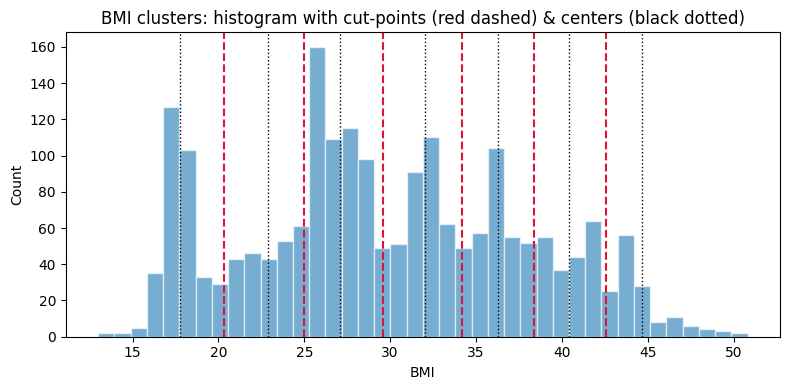


Row % crosstab of NObeyesdad vs KMeans-order labels (by BMI):


cluster_label_ordered,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
NObeyesdad,,,,,,,
Insufficient_Weight,100.0,0.0,0.0,0.0,0.0,0.0,0.0
Normal_Weight,23.0,77.0,0.0,0.0,0.0,0.0,0.0
Obesity_Type_I,0.0,0.0,5.7,0.0,0.0,0.0,94.3
Obesity_Type_II,0.0,0.0,83.2,15.8,0.0,0.0,1.0
Obesity_Type_III,0.0,0.0,5.6,52.5,42.0,0.0,0.0
Overweight_Level_I,0.0,4.3,0.0,0.0,0.0,95.7,0.0
Overweight_Level_II,0.0,0.0,0.0,0.0,0.0,95.5,4.5


In [48]:
# =========================
# Cluster BMI and read lower/upper cut-points
# =========================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

# 0) Data — use dfc if available; else df
D = dfc.copy() if "dfc" in globals() else df.copy()

# Ensure BMI exists & numeric
for c in ["Height","Weight"]:
    if c in D.columns:
        D[c] = pd.to_numeric(D[c], errors="coerce")
if {"Height","Weight"}.issubset(D.columns) and "BMI" not in D.columns:
    D["BMI"] = D["Weight"] / (D["Height"]**2)
D["BMI"] = pd.to_numeric(D["BMI"], errors="coerce")

# Optional: clip extreme BMIs to avoid a few points dominating 1-D kmeans
BMI_CLIP = (12, 60)
bmi = D["BMI"].clip(*BMI_CLIP).dropna().to_numpy().reshape(-1, 1)

# 1) KMeans on BMI (1-D)
K = 7  # set to 7 to match NObeyesdad levels; you can try 6 or 5 if desired
km = KMeans(n_clusters=K, random_state=42, n_init="auto")
labels = km.fit_predict(bmi)
centers = km.cluster_centers_.ravel()

# 2) Sort clusters by BMI (low -> high) and compute boundaries
order = np.argsort(centers)
cent_sorted = centers[order]
# boundaries are midpoints between adjacent centroids
bounds = [(cent_sorted[i] + cent_sorted[i+1]) / 2 for i in range(K-1)]
bounds = np.array(bounds)

# Map each point to its position in the sorted order (0..K-1)
inv_order = {orig:i for i, orig in enumerate(order)}
sorted_labels = np.array([inv_order[l] for l in labels])

# 3) Build a summary table with empirical mins/maxes and majority NObeyesdad
# attach back to the rows we used
tmp = D.loc[D["BMI"].notna(), ["BMI", "NObeyesdad"]].copy()
tmp["BMI"] = tmp["BMI"].clip(*BMI_CLIP).to_numpy()
tmp["cluster"] = sorted_labels

rows = []
for k in range(K):
    members = tmp.loc[tmp["cluster"]==k]
    lo_emp, hi_emp = members["BMI"].min(), members["BMI"].max()
    lo_theo = -np.inf if k==0 else bounds[k-1]
    hi_theo =  np.inf if k==K-1 else bounds[k]
    maj_label, maj_share = None, np.nan
    if "NObeyesdad" in tmp.columns:
        vc = members["NObeyesdad"].value_counts(normalize=True)
        if len(vc):
            maj_label, maj_share = vc.index[0], float(vc.iloc[0]*100)
    rows.append({
        "cluster_rank": k,
        "centroid_BMI": round(cent_sorted[k], 2),
        "range_BMI_[lo,hi)": f"[{lo_theo:.2f}, {hi_theo:.2f})",
        "empirical_min": round(lo_emp, 2),
        "empirical_max": round(hi_emp, 2),
        "n": int(len(members)),
        "majority_NObeyesdad": maj_label if maj_label is not None else "",
        "majority_%": round(maj_share, 1) if not np.isnan(maj_share) else ""
    })

summary = pd.DataFrame(rows)
display(summary)

# 4) Suggested mapping from low->high cluster to dataset labels
suggested = [
    "Insufficient_Weight",
    "Normal_Weight",
    "Overweight_Level_I",
    "Overweight_Level_II",
    "Obesity_Type_I",
    "Obesity_Type_II",
    "Obesity_Type_III",
][:K]
summary["suggested_label"] = suggested
display(summary)

# 5) Histogram with boundaries & centroids
plt.figure(figsize=(8,4))
plt.hist(bmi.ravel(), bins=40, alpha=0.6, edgecolor="white")
for x in bounds:
    plt.axvline(x, color="crimson", linestyle="--", linewidth=1.5)
for c in cent_sorted:
    plt.axvline(c, color="black", linestyle=":", linewidth=1)
plt.title("BMI clusters: histogram with cut-points (red dashed) & centers (black dotted)")
plt.xlabel("BMI"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# 6) (Optional) Evaluate agreement with NObeyesdad via majority vote mapping
if "NObeyesdad" in tmp.columns:
    # Map each cluster to suggested label purely by order; compare
    tmp["cluster_label_ordered"] = tmp["cluster"].map({i: suggested[i] for i in range(K)})
    ct = pd.crosstab(tmp["NObeyesdad"], tmp["cluster_label_ordered"], normalize="index")*100
    print("\nRow % crosstab of NObeyesdad vs KMeans-order labels (by BMI):")
    display(ct.round(1))



LogReg CV f1_weighted: mean=0.9018 ± 0.0202
LogReg Test -> Acc=0.9258  Prec=0.9252  Rec=0.9258  F1=0.9251
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      1.00      0.96        53
      Normal_Weight       0.91      0.86      0.88        57
     Obesity_Type_I       0.94      0.94      0.94        70
    Obesity_Type_II       0.95      1.00      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.85      0.82      0.83        55
Overweight_Level_II       0.88      0.86      0.87        58

           accuracy                           0.93       418
          macro avg       0.92      0.92      0.92       418
       weighted avg       0.93      0.93      0.93       418



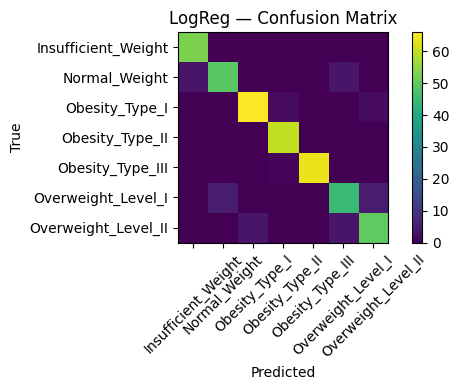


DecisionTree CV f1_weighted: mean=0.9677 ± 0.0052
DecisionTree Test -> Acc=0.9761  Prec=0.9764  Rec=0.9761  F1=0.9761
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        53
      Normal_Weight       0.97      0.98      0.97        57
     Obesity_Type_I       0.97      0.99      0.98        70
    Obesity_Type_II       0.97      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.98      0.93      0.95        55
Overweight_Level_II       0.95      0.98      0.97        58

           accuracy                           0.98       418
          macro avg       0.98      0.98      0.98       418
       weighted avg       0.98      0.98      0.98       418



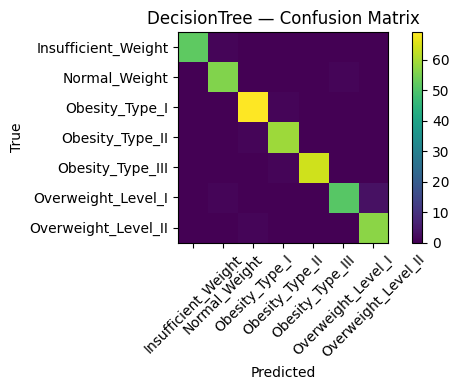


RandomForest CV f1_weighted: mean=0.9797 ± 0.0044
RandomForest Test -> Acc=0.9809  Prec=0.9817  Rec=0.9809  F1=0.9810
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        53
      Normal_Weight       0.92      0.98      0.95        57
     Obesity_Type_I       1.00      1.00      1.00        70
    Obesity_Type_II       0.98      1.00      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.96      0.96      0.96        55
Overweight_Level_II       1.00      0.95      0.97        58

           accuracy                           0.98       418
          macro avg       0.98      0.98      0.98       418
       weighted avg       0.98      0.98      0.98       418



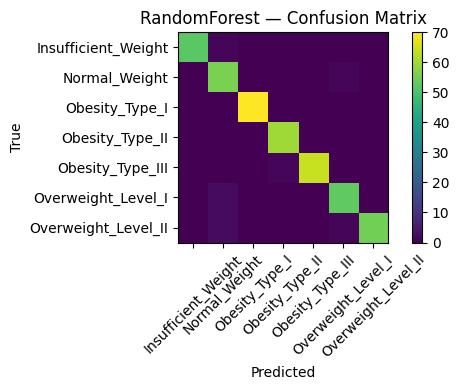

In [49]:
# ========= Classification: predict NObeyesdad =========
import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 0) get a working dataframe
dfX = (df_anom_treated.copy() if "df_anom_treated" in globals()
       else dfc.copy() if "dfc" in globals()
       else df.copy())
dfX.columns = [c.strip() for c in dfX.columns]
if "CH20" in dfX.columns and "CH2O" not in dfX.columns:
    dfX = dfX.rename(columns={"CH20": "CH2O"})

# ensure BMI exists (used as a feature here)
if {"Height","Weight"}.issubset(dfX.columns) and "BMI" not in dfX.columns:
    dfX["BMI"] = pd.to_numeric(dfX["Weight"], errors="coerce") / (pd.to_numeric(dfX["Height"], errors="coerce")**2)

target = "NObeyesdad"
assert target in dfX.columns, "NObeyesdad not found."
y = dfX[target].astype("category")
X = dfX.drop(columns=[target])

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# column types
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# preprocess
numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler())])
categorical = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore"))])
pre = ColumnTransformer([("num", numeric, num_cols),
                         ("cat", categorical, cat_cols)])

# models
models = {
    "LogReg": Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=400, random_state=42))]),
    "DecisionTree": Pipeline([("pre", pre), ("clf", DecisionTreeClassifier(random_state=42))]),
    "RandomForest": Pipeline([("pre", pre), ("clf", RandomForestClassifier(n_estimators=300, random_state=42))]),
}

# CV + test evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def eval_model(name, pipe):
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_weighted", n_jobs=-1)
    print(f"{name} CV f1_weighted: mean={scores.mean():.4f} ± {scores.std():.4f}")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr, re, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)
    print(f"{name} Test -> Acc={acc:.4f}  Prec={pr:.4f}  Rec={re:.4f}  F1={f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    # confusion matrix
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(labels)), labels, rotation=45); plt.yticks(range(len(labels)), labels)
    plt.colorbar(); plt.tight_layout(); plt.show()

for n, m in models.items():
    print("\n==============================")
    eval_model(n, m)



=== Logistic Regression ===
Test: Acc=0.9258  Prec=0.9253  Rec=0.9258  F1=0.9251
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      1.00      0.96        53
      Normal_Weight       0.91      0.84      0.87        57
     Obesity_Type_I       0.94      0.94      0.94        70
    Obesity_Type_II       0.95      1.00      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.85      0.84      0.84        55
Overweight_Level_II       0.88      0.86      0.87        58

           accuracy                           0.93       418
          macro avg       0.92      0.92      0.92       418
       weighted avg       0.93      0.93      0.93       418



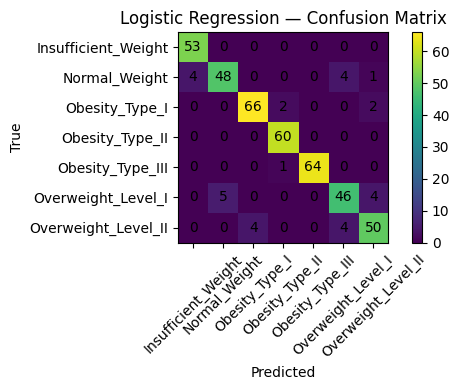

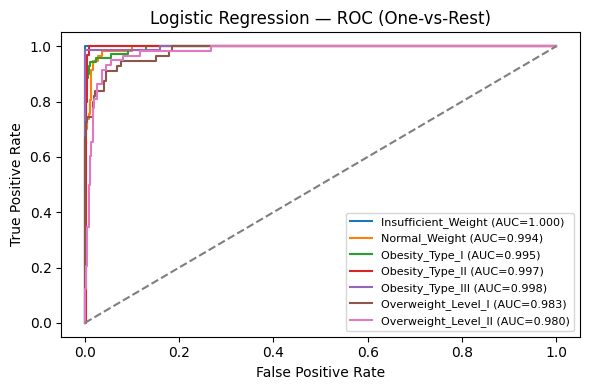

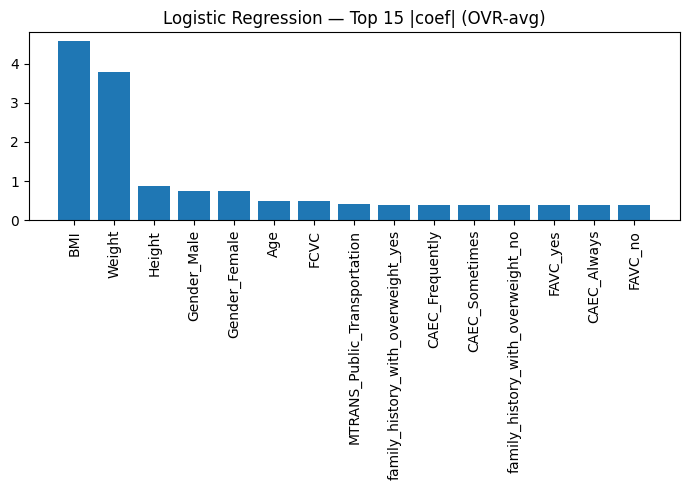


=== Decision Tree ===
Test: Acc=0.9713  Prec=0.9713  Rec=0.9713  F1=0.9712
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        53
      Normal_Weight       0.97      1.00      0.98        57
     Obesity_Type_I       0.99      0.99      0.99        70
    Obesity_Type_II       0.97      1.00      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.94      0.91      0.93        55
Overweight_Level_II       0.93      0.93      0.93        58

           accuracy                           0.97       418
          macro avg       0.97      0.97      0.97       418
       weighted avg       0.97      0.97      0.97       418



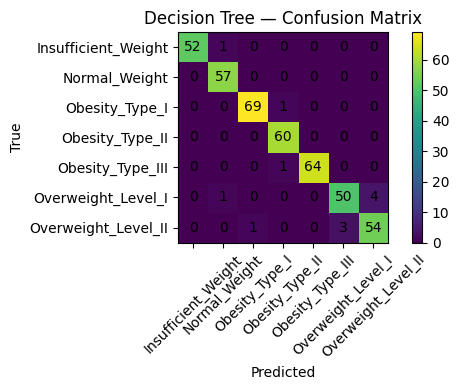

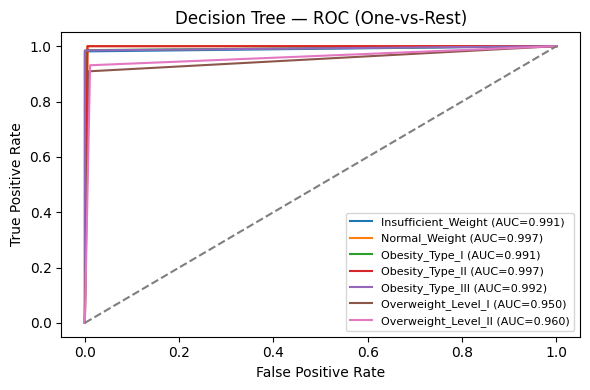

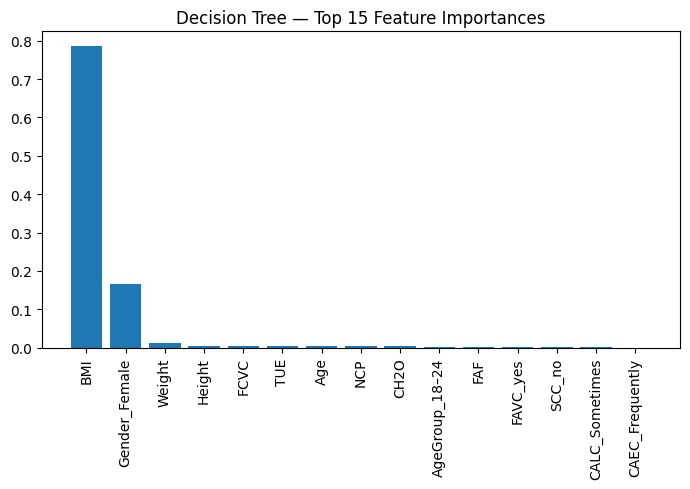


=== Random Forest ===
Test: Acc=0.9833  Prec=0.9847  Rec=0.9833  F1=0.9834
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00        53
      Normal_Weight       0.90      1.00      0.95        57
     Obesity_Type_I       1.00      1.00      1.00        70
    Obesity_Type_II       0.98      1.00      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       1.00      0.93      0.96        55
Overweight_Level_II       1.00      0.97      0.98        58

           accuracy                           0.98       418
          macro avg       0.98      0.98      0.98       418
       weighted avg       0.98      0.98      0.98       418



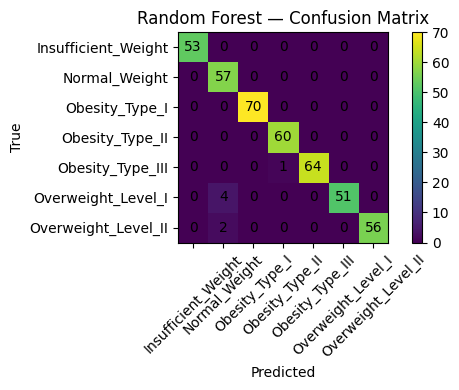

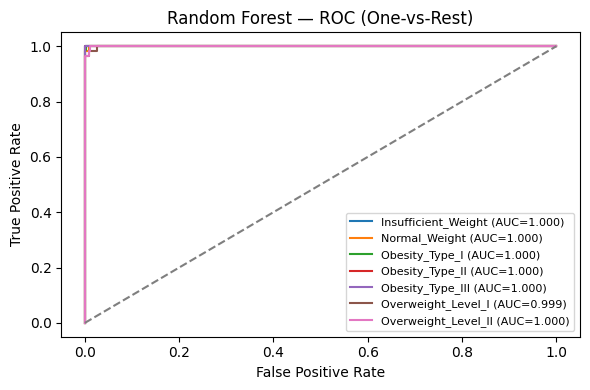

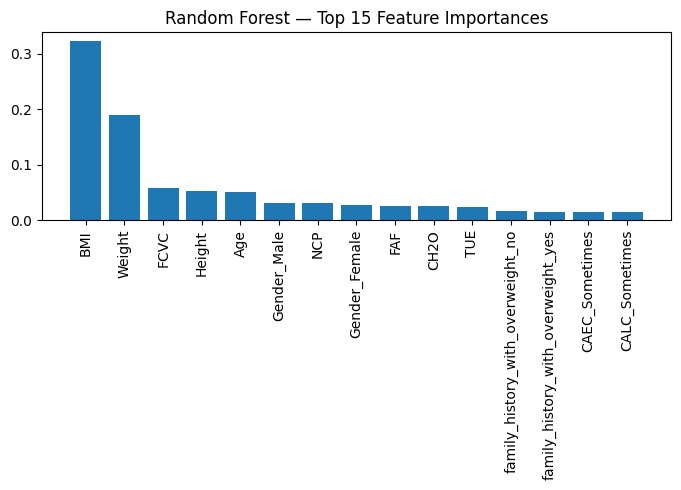

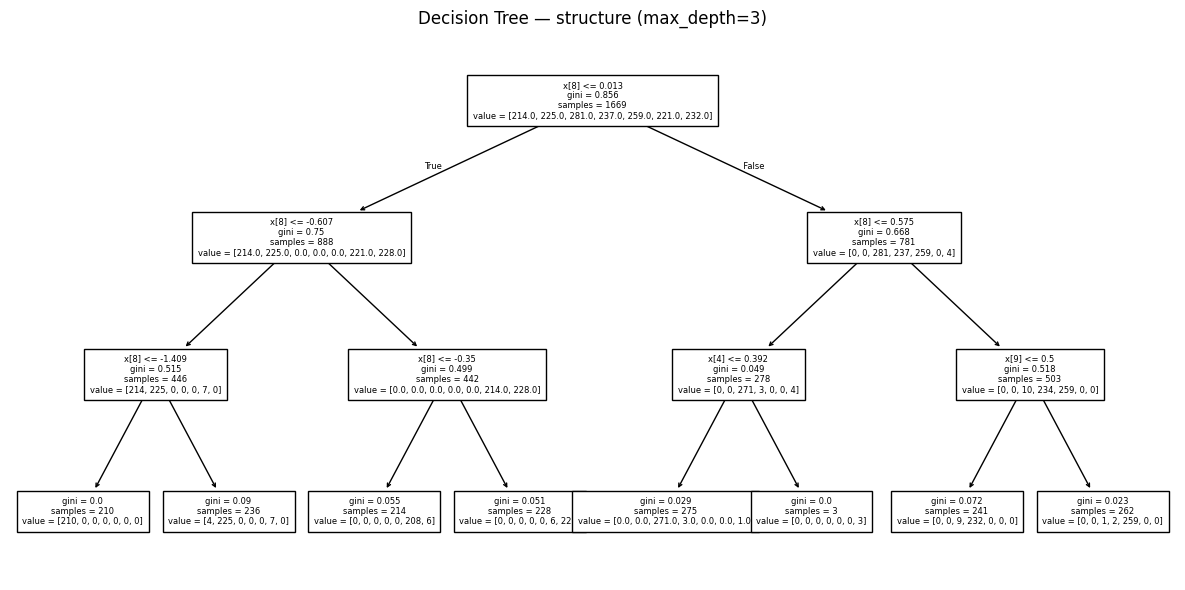

In [51]:
# ============================================
# Models & Graphs (NO anomaly treatment)
# Logistic Regression, Decision Tree, Random Forest
# ============================================
import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_recall_fscore_support, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# ---------- 0) Get data (no anomaly treatment) ----------
RAW_PATH = r"ObesityDataSet_raw_and_data_sinthetic.csv"  # change if not in the same folder

if "dfc" in globals():
    data = dfc.copy()
elif "df" in globals():
    data = df.copy()
else:
    data = pd.read_csv(RAW_PATH)

data.columns = [c.strip() for c in data.columns]
# Fix common typo CH20 -> CH2O
if "CH20" in data.columns and "CH2O" not in data.columns:
    data = data.rename(columns={"CH20": "CH2O"})

# Ensure BMI exists (useful predictor)
if {"Height","Weight"}.issubset(data.columns) and "BMI" not in data.columns:
    data["BMI"] = pd.to_numeric(data["Weight"], errors="coerce") / (pd.to_numeric(data["Height"], errors="coerce")**2)

target = "NObeyesdad"
assert target in data.columns, "NObeyesdad column not found."
y = data[target].astype("category")
X = data.drop(columns=[target])

# ---------- 1) Train / test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- 2) Preprocess ----------
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler())])
categorical = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore"))])

pre = ColumnTransformer([("num", numeric, num_cols),
                         ("cat", categorical, cat_cols)])

# ---------- 3) Models ----------
logreg = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=500, random_state=42))])
dtree  = Pipeline([("pre", pre), ("clf", DecisionTreeClassifier(random_state=42))])
rf     = Pipeline([("pre", pre), ("clf", RandomForestClassifier(n_estimators=300, random_state=42))])

models = {
    "Logistic Regression": logreg,
    "Decision Tree": dtree,
    "Random Forest": rf,
}

# ---------- 4) Plot helpers ----------
def plot_confusion(mname, model, Xt, yt):
    labels = np.unique(yt)
    cm = confusion_matrix(yt, model.predict(Xt), labels=labels)
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{mname} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar()
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc(mname, model, Xt, yt):
    if not hasattr(model, "predict_proba"):
        print(f"{mname}: predict_proba not available, skipping ROC.")
        return
    lb = LabelBinarizer()
    y_bin = lb.fit_transform(yt)                         # shape (n_samples, K)
    y_score = model.predict_proba(Xt)
    if isinstance(y_score, list):                        # robust for older sklearn
        y_score = np.column_stack(y_score)
    plt.figure(figsize=(6,4))
    for i in range(y_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{lb.classes_[i]} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(f"{mname} — ROC (One-vs-Rest)")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

def get_feature_names(preprocessor):
    feats = []
    if len(num_cols):
        feats.extend(num_cols)
    if len(cat_cols):
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        feats.extend(ohe.get_feature_names_out(cat_cols).tolist())
    return feats

def plot_tree_feature_importance(mname, model, topn=15):
    clf = model.named_steps["clf"]
    if not hasattr(clf, "feature_importances_"):
        print(f"{mname}: no feature_importances_, skipping.")
        return
    feats = get_feature_names(model.named_steps["pre"])
    importances = clf.feature_importances_
    idx = np.argsort(importances)[::-1][:topn]
    plt.figure(figsize=(7,5))
    plt.bar(range(len(idx)), importances[idx])
    plt.xticks(range(len(idx)), [feats[i] for i in idx], rotation=90)
    plt.title(f"{mname} — Top {topn} Feature Importances")
    plt.tight_layout()
    plt.show()

def plot_logreg_coefficients(model, topn=15):
    clf = model.named_steps["clf"]
    coefs = clf.coef_                              # shape (K, n_features)
    feats = get_feature_names(model.named_steps["pre"])
    abs_mean = np.mean(np.abs(coefs), axis=0)      # OVR-average |coef|
    idx = np.argsort(abs_mean)[::-1][:topn]
    plt.figure(figsize=(7,5))
    plt.bar(range(len(idx)), abs_mean[idx])
    plt.xticks(range(len(idx)), [feats[i] for i in idx], rotation=90)
    plt.title(f"Logistic Regression — Top {topn} |coef| (OVR-avg)")
    plt.tight_layout()
    plt.show()

def plot_small_tree_structure(model, max_depth=3):
    if not isinstance(model.named_steps["clf"], DecisionTreeClassifier):
        return
    Xtr = model.named_steps["pre"].transform(X_train)
    ytr = y_train.to_numpy()
    shallow = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
    shallow.fit(Xtr, ytr)
    plt.figure(figsize=(12,6))
    plot_tree(shallow, max_depth=max_depth, filled=False, fontsize=6)
    plt.title(f"Decision Tree — structure (max_depth={max_depth})")
    plt.tight_layout()
    plt.show()

# ---------- 5) Train + graphs ----------
for name, pipe in models.items():
    print(f"\n=== {name} ===")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr, re, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)
    print(f"Test: Acc={acc:.4f}  Prec={pr:.4f}  Rec={re:.4f}  F1={f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # 1) Confusion matrix
    plot_confusion(name, pipe, X_test, y_test)

    # 2) ROC curves (multiclass OVR)
    plot_multiclass_roc(name, pipe, X_test, y_test)

    # 3) Feature importance / coefficients
    if name == "Logistic Regression":
        plot_logreg_coefficients(pipe, topn=15)
    else:
        plot_tree_feature_importance(name, pipe, topn=15)

# Optional: a small, readable tree structure preview
plot_small_tree_structure(models["Decision Tree"], max_depth=3)


Further Analysis


DecisionTreeReg CV MAE: mean=2.410 ± 0.157
DecisionTreeReg Test -> MAE=2.708  RMSE=4.607  R²=0.676


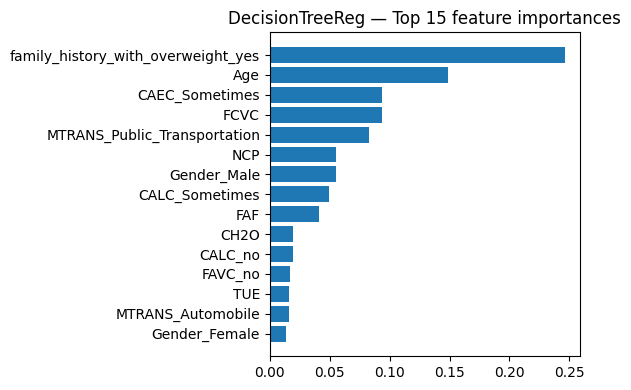


RandomForestReg CV MAE: mean=1.980 ± 0.031
RandomForestReg Test -> MAE=2.052  RMSE=3.161  R²=0.848


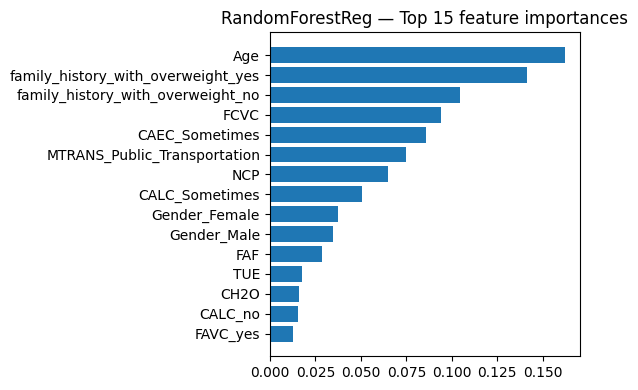

In [53]:
# ========= Regression: predict BMI =========
import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 0) data
dfR = (df_anom_treated.copy() if "df_anom_treated" in globals()
       else dfc.copy() if "dfc" in globals()
       else df.copy())
dfR.columns = [c.strip() for c in dfR.columns]
if "CH20" in dfR.columns and "CH2O" not in dfR.columns:
    dfR = dfR.rename(columns={"CH20": "CH2O"})

# ensure BMI exists
if {"Height","Weight"}.issubset(dfR.columns) and "BMI" not in dfR.columns:
    dfR["BMI"] = pd.to_numeric(dfR["Weight"], errors="coerce") / (pd.to_numeric(dfR["Height"], errors="coerce")**2)

target = "BMI"
assert target in dfR.columns, "BMI not found."
y = pd.to_numeric(dfR[target], errors="coerce")

# drop leakage features & the class label (if present)
drop_cols = [c for c in ["BMI","Height","Weight","NObeyesdad"] if c in dfR.columns]
X = dfR.drop(columns=drop_cols)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# columns
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# preprocess (RobustScaler handles outliers better)
numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler", RobustScaler())])
categorical = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore"))])
pre = ColumnTransformer([("num", numeric, num_cols),
                         ("cat", categorical, cat_cols)])

# models
reg_models = {
    "DecisionTreeReg": Pipeline([("pre", pre), ("reg", DecisionTreeRegressor(random_state=42))]),
    "RandomForestReg": Pipeline([("pre", pre), ("reg", RandomForestRegressor(n_estimators=300, random_state=42))]),
}

# CV + test evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def eval_reg(name, pipe):
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
    print(f"{name} CV MAE: mean={-scores.mean():.3f} ± {scores.std():.3f}")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Test -> MAE={mae:.3f}  RMSE={rmse:.3f}  R²={r2:.3f}")

    # feature importance (RF only)
    if hasattr(pipe.named_steps["reg"], "feature_importances_"):
        # get feature names after one-hot
        preprocessor = pipe.named_steps["pre"]
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_feats = []
        if len(cat_cols):
            cat_feats = ohe.get_feature_names_out(cat_cols).tolist()
        feats = num_cols + cat_feats
        importances = pipe.named_steps["reg"].feature_importances_
        idx = np.argsort(importances)[::-1][:15]
        plt.figure(figsize=(6,4))
        plt.barh([feats[i] for i in idx][::-1], importances[idx][::-1])
        plt.title(f"{name} — Top 15 feature importances")
        plt.tight_layout(); plt.show()

for n, m in reg_models.items():
    print("\n==============================")
    eval_reg(n, m)
